In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import display
from keras.utils.vis_utils import plot_model

In [ ]:
if not os.path.isfile('processed_dataset.zip'):
  os.system(' '.join(['cp', 'drive/MyDrive/IT416/processed_dataset.zip', 'processed_dataset.zip']))

In [ ]:
if not os.path.isdir('processed_dataset'):
  os.system(' '.join(['unzip', 'processed_dataset.zip']))

In [ ]:
def get_dataset(num_people):
  x1 = []
  x2 = []
  y  = []
  for i in range(num_people):
      for j in range(10):
          path = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'face' + '/' + str(j+1) + '.pgm'
          image = cv2.imread(path, -1)
          image = cv2.resize(image, (12, 12))
          image = image.reshape(12, 12, 1)
          x1.append(image)
      gait_folder = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'gait' + '/'
      styles = os.listdir(gait_folder)
      styles.sort()
      for j, style in enumerate(styles):
          style_folder = gait_folder + style + '/'
          angles = os.listdir(style_folder)
          angles.sort()
          x = []
          for angle in angles:
              angle_folder = style_folder + angle + '/'
              images = os.listdir(angle_folder)
              images.sort()
              random.shuffle(images)
              images = images[: 16]
              images.sort()
              xx = []
              for image in images:
                  path = angle_folder + image
                  img = cv2.imread(path, -1)
                  img = cv2.resize(img, (32, 32))
                  img = np.array(img, dtype=np.float16)
                  xx.append(img)
              xx = np.array(xx, dtype=np.float16)
              x.append(xx)
          x = np.stack(x, axis=3)
          x2.append(x)
      for j in range(10):
          y.append(i)
  x1 = np.array(x1, dtype = np.float32)
  x2 = np.array(x2, dtype = np.float32)
  y = tf.keras.utils.to_categorical(y)
  x1, x2, y = shuffle(x1, x2, y)
  return x1, x2, y

In [ ]:
num_people = 40
x_face, x_gait, y = get_dataset(num_people)

print('x_face:', x_face.shape)
print('x_gait:', x_gait.shape)
print('y     :', y.shape)

x_face: (400, 12, 12, 1)
x_gait: (400, 16, 32, 32, 11)
y     : (400, 40)


In [ ]:
face_input = tf.keras.layers.Input(shape = (12, 12, 1), name = 'face_input')

face_encoder = tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', name = 'face_conv_1')(face_input)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_1')(face_encoder)
face_encoder = tf.keras.layers.Flatten(name = 'face_flatten_1')(face_encoder)
face_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'face_dense_1')(face_encoder)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_2')(face_encoder)
face_encoder = tf.keras.layers.BatchNormalization()(face_encoder)

gait_input = tf.keras.layers.Input(shape = (16, 32, 32, 11), name = 'gait_input')

gait_encoder = tf.keras.layers.ConvLSTM2D(16, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_1')(gait_input)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_1')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(8, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_2')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_2')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(1, kernel_size = 3, name = 'gait_convlstm_3')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_3')(gait_encoder)
gait_encoder = tf.keras.layers.Flatten(name = 'gait_flatten_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'gait_dense_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_4')(gait_encoder)
gait_encoder = tf.keras.layers.BatchNormalization()(gait_encoder)

def weighted_average(tensors):
  alpha = 0.5
  face = tensors[0]
  gait = tensors[1]
  weighted_average = alpha * face + (1 - alpha) * gait
  return weighted_average

decoder = tf.keras.layers.Lambda(weighted_average, name = 'face_gait_weighted_average')([face_encoder, gait_encoder])

decoder = tf.keras.layers.Dense(40, activation = 'softmax', name = 'output')(decoder)

model = tf.keras.models.Model(
      inputs = [face_input, gait_input], 
      outputs = decoder)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gait_input (InputLayer)        [(None, 16, 32, 32,  0           []                               
                                 11)]                                                             
                                                                                                  
 gait_convlstm_1 (ConvLSTM2D)   (None, 16, 30, 30,   15616       ['gait_input[0][0]']             
                                16)                                                               
                                                                                                  
 gait_dropout_1 (Dropout)       (None, 16, 30, 30,   0           ['gait_convlstm_1[0][0]']        
                                16)                                                           

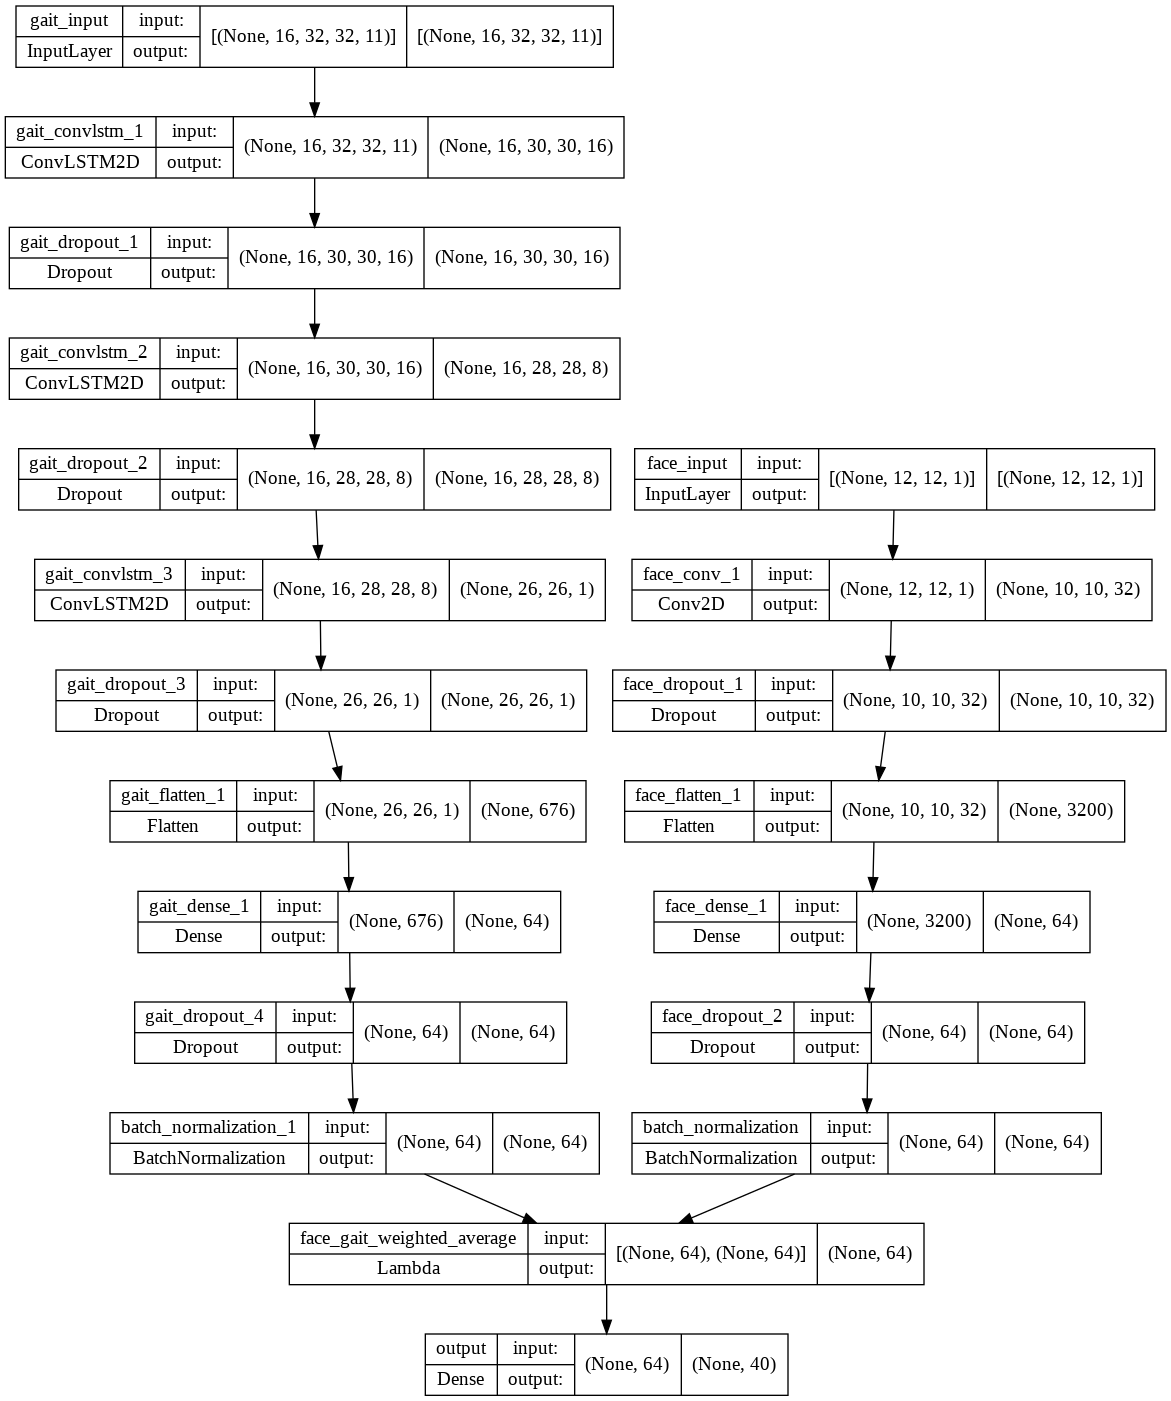

In [ ]:
plot = plot_model(model, show_shapes = True, to_file = 'model.png', show_layer_names = True)
display(plot)

In [ ]:
EPOCHS = 60
BATCH_SIZE = 4
VALID_SPLIT = 0.3

acc_train = []
acc_val = []

In [ ]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/60
70/70 [==============================] - 34s 266ms/step - loss: 3.8356 - accuracy: 0.0107 - val_loss: 3.7997 - val_accuracy: 0.0083
Epoch 2/60
70/70 [==============================] - 17s 245ms/step - loss: 3.7623 - accuracy: 0.0286 - val_loss: 3.5659 - val_accuracy: 0.0583
Epoch 3/60
70/70 [==============================] - 17s 247ms/step - loss: 3.6329 - accuracy: 0.0571 - val_loss: 3.5053 - val_accuracy: 0.1167
Epoch 4/60
70/70 [==============================] - 17s 244ms/step - loss: 3.5323 - accuracy: 0.0821 - val_loss: 3.4886 - val_accuracy: 0.1083
Epoch 5/60
70/70 [==============================] - 17s 245ms/step - loss: 3.4337 - accuracy: 0.1107 - val_loss: 3.6606 - val_accuracy: 0.0250
Epoch 6/60
70/70 [==============================] - 17s 240ms/step - loss: 3.4853 - accuracy: 0.0964 - val_loss: 3.5369 - val_accuracy: 0.0833
Epoch 7/60
70/70 [==============================] - 17s 237ms/step - loss: 3.4247 - accuracy: 0.1179 - val_loss: 3.4451 - val_accuracy: 0.1583

In [ ]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/10
70/70 [==============================] - 18s 262ms/step - loss: 1.2917 - accuracy: 0.7857 - val_loss: 1.2647 - val_accuracy: 0.8000
Epoch 2/10
70/70 [==============================] - 17s 245ms/step - loss: 1.3377 - accuracy: 0.7607 - val_loss: 1.3407 - val_accuracy: 0.7417
Epoch 3/10
70/70 [==============================] - 17s 241ms/step - loss: 1.3114 - accuracy: 0.7786 - val_loss: 1.3355 - val_accuracy: 0.7417
Epoch 4/10
70/70 [==============================] - 17s 240ms/step - loss: 1.1508 - accuracy: 0.8214 - val_loss: 1.3547 - val_accuracy: 0.8167
Epoch 5/10
70/70 [==============================] - 17s 240ms/step - loss: 1.2127 - accuracy: 0.8107 - val_loss: 1.3004 - val_accuracy: 0.7000
Epoch 6/10
70/70 [==============================] - 17s 238ms/step - loss: 1.0823 - accuracy: 0.8250 - val_loss: 1.1308 - val_accuracy: 0.8417
Epoch 7/10
70/70 [==============================] - 18s 252ms/step - loss: 1.0330 - accuracy: 0.8536 - val_loss: 1.2305 - val_accuracy: 0.8083

In [ ]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/10
70/70 [==============================] - 17s 245ms/step - loss: 0.8152 - accuracy: 0.9000 - val_loss: 0.8303 - val_accuracy: 0.9000
Epoch 2/10
70/70 [==============================] - 17s 240ms/step - loss: 0.8611 - accuracy: 0.8821 - val_loss: 0.7659 - val_accuracy: 0.9083
Epoch 3/10
70/70 [==============================] - 18s 255ms/step - loss: 0.8865 - accuracy: 0.8607 - val_loss: 0.7973 - val_accuracy: 0.8833
Epoch 4/10
70/70 [==============================] - 17s 239ms/step - loss: 0.7393 - accuracy: 0.8929 - val_loss: 0.7806 - val_accuracy: 0.8750
Epoch 5/10
70/70 [==============================] - 17s 248ms/step - loss: 0.7227 - accuracy: 0.9000 - val_loss: 0.6987 - val_accuracy: 0.8833
Epoch 6/10
70/70 [==============================] - 18s 252ms/step - loss: 0.7115 - accuracy: 0.9179 - val_loss: 0.6698 - val_accuracy: 0.8833
Epoch 7/10
70/70 [==============================] - 17s 237ms/step - loss: 0.6377 - accuracy: 0.9107 - val_loss: 0.7611 - val_accuracy: 0.9000

In [ ]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/10
70/70 [==============================] - 18s 260ms/step - loss: 0.6810 - accuracy: 0.9143 - val_loss: 0.6065 - val_accuracy: 0.9000
Epoch 2/10
70/70 [==============================] - 17s 248ms/step - loss: 0.5696 - accuracy: 0.9321 - val_loss: 0.6655 - val_accuracy: 0.8917
Epoch 3/10
70/70 [==============================] - 17s 244ms/step - loss: 0.5651 - accuracy: 0.9393 - val_loss: 0.6099 - val_accuracy: 0.8917
Epoch 4/10
70/70 [==============================] - 17s 241ms/step - loss: 0.5954 - accuracy: 0.9143 - val_loss: 0.6253 - val_accuracy: 0.8917
Epoch 5/10
70/70 [==============================] - 16s 235ms/step - loss: 0.5411 - accuracy: 0.9393 - val_loss: 0.5529 - val_accuracy: 0.9250
Epoch 6/10
70/70 [==============================] - 17s 247ms/step - loss: 0.5481 - accuracy: 0.9286 - val_loss: 0.5611 - val_accuracy: 0.9083
Epoch 7/10
70/70 [==============================] - 17s 236ms/step - loss: 0.5061 - accuracy: 0.9429 - val_loss: 0.6651 - val_accuracy: 0.8833

In [ ]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/10
70/70 [==============================] - 17s 244ms/step - loss: 0.4546 - accuracy: 0.9536 - val_loss: 0.5687 - val_accuracy: 0.8917
Epoch 2/10
70/70 [==============================] - 17s 238ms/step - loss: 0.4727 - accuracy: 0.9250 - val_loss: 0.5839 - val_accuracy: 0.9083
Epoch 3/10
70/70 [==============================] - 17s 238ms/step - loss: 0.4974 - accuracy: 0.9250 - val_loss: 0.5009 - val_accuracy: 0.8833
Epoch 4/10
70/70 [==============================] - 17s 241ms/step - loss: 0.4895 - accuracy: 0.9429 - val_loss: 0.5592 - val_accuracy: 0.9000
Epoch 5/10
70/70 [==============================] - 18s 255ms/step - loss: 0.5245 - accuracy: 0.9250 - val_loss: 0.4958 - val_accuracy: 0.9083
Epoch 6/10
70/70 [==============================] - 17s 239ms/step - loss: 0.4384 - accuracy: 0.9429 - val_loss: 0.5940 - val_accuracy: 0.8667
Epoch 7/10
70/70 [==============================] - 17s 242ms/step - loss: 0.4806 - accuracy: 0.9464 - val_loss: 0.5939 - val_accuracy: 0.8833

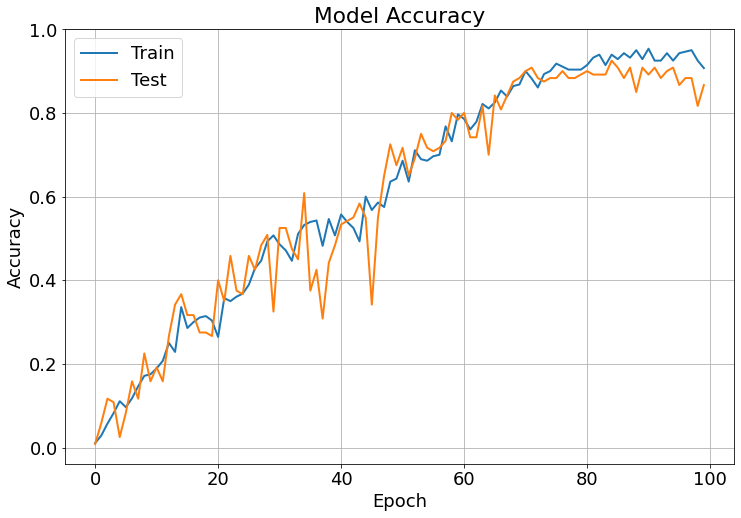

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 18

plt.plot(acc_train, linewidth=2)
plt.plot(acc_val, linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()